# Image Pipeline Analysis and Tests

## Questions:
### Part 1:
#### How did you verify that you are parsing the contours correctly?
I implemented the DicomContourReader, which creates and string file ID extracted from the file names and stores it in a dictionary together with the file name. To ensure the the correct image-mask pair is loaded, the file IDs for a dicom image and a contour file are compared.

In addition, I plotted the images and the corresponding contours to verify the contour location.

#### What changes did you make to the code, if any, in order to integrate it into our production code base?
I created a class hierarchy to create an API-like functionality and easy to maintain modules:
- ImageTools: the provided, general purpose function, which were modified.
- DicomContourReader: subclass of DicomReader ( which is subclass of ImageTools). Parses all the image and contour data.
- ImagePipeline: subclass of ImageTools. Calls DicomContourReader to parse file names and creates batches for training 

### Part 2: 
#### Did you change anything from the pipelines built in Parts 1 to better streamline the pipeline built in Part 2? If so, what? If not, is there anything that you can imagine changing in the future?
The DicomContourReader in Part 1 is an independent and standalone tool. However, having Part 2 in mind, I designed the corresponding methods like extracting matching file names. One thing I changed after working on Part 2 was that I made the ImageTools class the super class of all other classes in order to share code across different tools and benefit from already tested code in DicomContourReader. After finishing all classes from Part 1, I was immadiately able to integrate them in Part 2.

In terms of suggestions for future improvements:
- The file matching between dicom and contour file can be improved. Establish a file name convention that more stable and identical between Dicom and Contour files. The Pipeline should then be adjusted to that.
- The pipeline has to be adjusted for different image size and pixel spacings. If some of the images have different sizes, the images have to be resized using interpolation.

#### How do you/did you verify that the pipeline was working correctly? Given the pipeline you have built, can you see any deficiencies that you would change if you had more time? If not, can you think of any improvements/enhancements to the pipeline that you could build in?

Tests (also see below):
- I implented tests in this notebook.
- I verified the file name of dicom images and contour files.
- I verified the batch creation by checking the uniform data distribution of about 1000 iteration (1000/8 epochs)
- I plotted images of all batches for one epoch.

Improvements:
- Test pipeline with a different data set.
- Add more flexibility for different image formats.
- Add ability to sample specific or constrained batches, e.g. that one batch does not include several images from one patient.
- Align the exception handling with the production environment.
- Right now, all the files are stored in memory. For large data sets, this should be improved by just storing file locations and parse files when batch is created.



In [1]:
import dicom
from dicom.errors import InvalidDicomError

import numpy as np
from PIL import Image, ImageDraw

import os,csv

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from ImagePipeline import ImageTools, DicomReader, DicomContourReader, ImagePipeline

In [3]:
!ls

Analysis.ipynb     ImagePipeline.py   __init__.py        final_data.tar
DicomImagePipeline ImagePipeline.pyc  final_data         parsing.py


### Test DicomReader

In [4]:
d=DicomReader('final_data/dicoms/SCD0000101/')
dc = DicomContourReader('final_data/dicoms/SCD0000101/','final_data/contourfiles/SC-HF-I-1/i-contours/')

assert len( dc.getAllFilePairs() )==18

Found 240 dcm images
Found 240 dcm images
Found 18 contour files


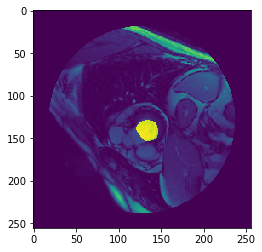

In [5]:
ima,mask = dc.getDicomImageAndMask('0048')
plt.imshow(800*np.array(mask)+np.array(ima))

### Test Image Pipeline

In [6]:
np.random.seed(1234)
ip = ImagePipeline('final_data/dicoms/','final_data/contourfiles/','final_data/link.csv')

assert(ip._ndata==96)

Found 240 dcm images
Found 18 contour files
Total # files: 18
Found 260 dcm images
Found 18 contour files
Total # files: 36
Found 200 dcm images
Found 20 contour files
Total # files: 56
Found 220 dcm images
Found 18 contour files
Total # files: 74
Found 220 dcm images
Found 22 contour files
Total # files: 96


In [7]:
# check batch sampling 
for k in range(12):
    print ip.getNextBatchIndices()

[40, 78, 92, 90, 63, 61, 35, 81]
[27, 54, 1, 79, 56, 55, 59, 70]
[9, 94, 71, 33, 36, 4, 10, 68]
[45, 29, 57, 44, 39, 89, 64, 77]
[80, 62, 74, 21, 18, 72, 82, 22]
[6, 8, 41, 16, 20, 25, 48, 75]
[31, 88, 5, 66, 32, 52, 13, 87]
[17, 28, 46, 84, 42, 60, 7, 51]
[14, 65, 12, 19, 2, 3, 0, 11]
[67, 93, 34, 37, 91, 50, 95, 73]
[69, 58, 86, 85, 43, 30, 26, 23]
[49, 15, 24, 76, 53, 38, 83, 47]


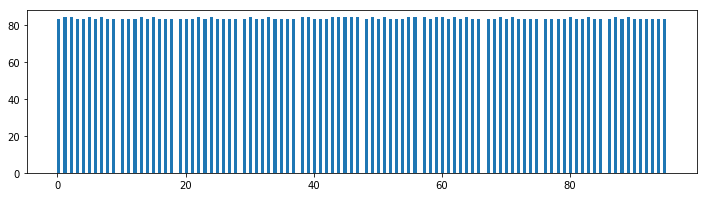

In [77]:
# check if batch sampling is uniform across data points
tmp =[]
for k in range(1000):
    tmp+= ip.getNextBatchIndices()
    
plt.figure(figsize=(12,3))
_=plt.hist(tmp,bins=200)

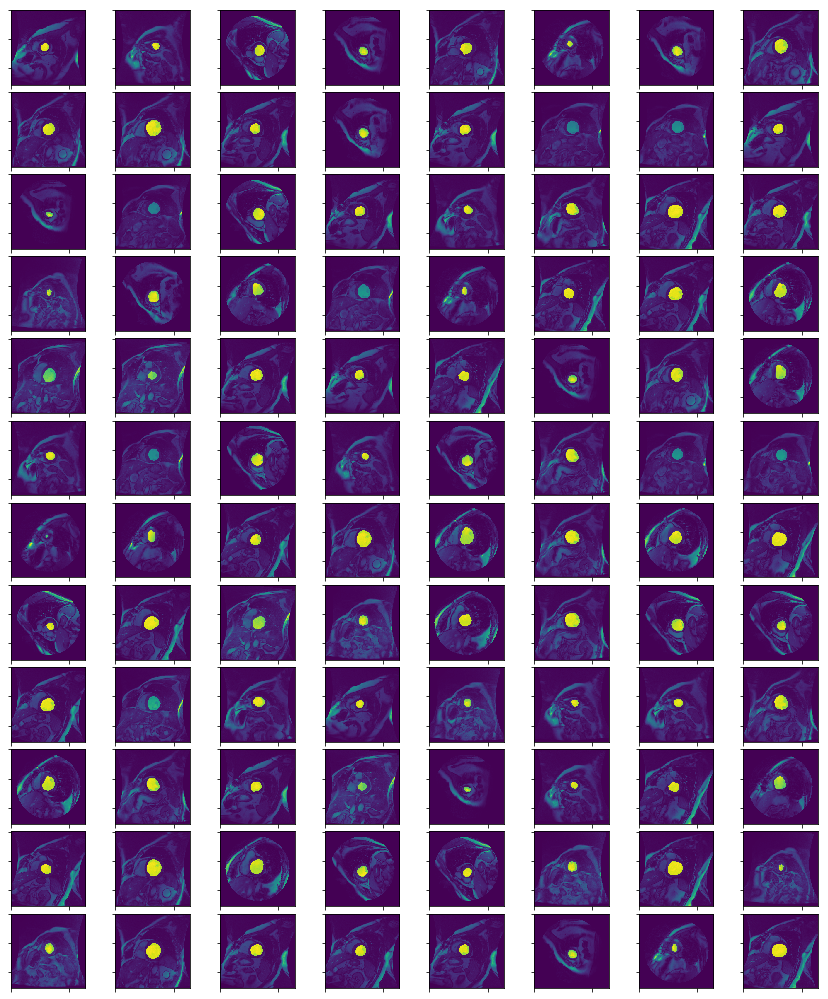

In [78]:
# visualize batches

pcnt=0
plt.figure(figsize=(15,18))
for ib in range(12):
    a,b = ip.getNextBatch()
    for k in range(8):
        pcnt+=1
        ax=plt.subplot(12,8,pcnt)
        plt.imshow(a[k]+800*b[k])
        ax.set_xticklabels(())
        ax.set_yticklabels(())
plt.subplots_adjust(hspace = .1, wspace = .001)

### Basic Tests

In [9]:
dcmFile = 'final_data/dicoms/SCD0000101/48.dcm'
icontFile = 'final_data/contourfiles/SC-HF-I-1/i-contours/IM-0001-0048-icontour-manual.txt'

it = ImageTools()
dcmData   = it.parse_dicom_file(dcmFile)
icontPoly = it.parse_contour_file(icontFile)

width, height =256,256
icontMask = it.poly_to_mask(icontPoly, dcmData['width'], dcmData['height'])
ima = dcmData['pixel_data']

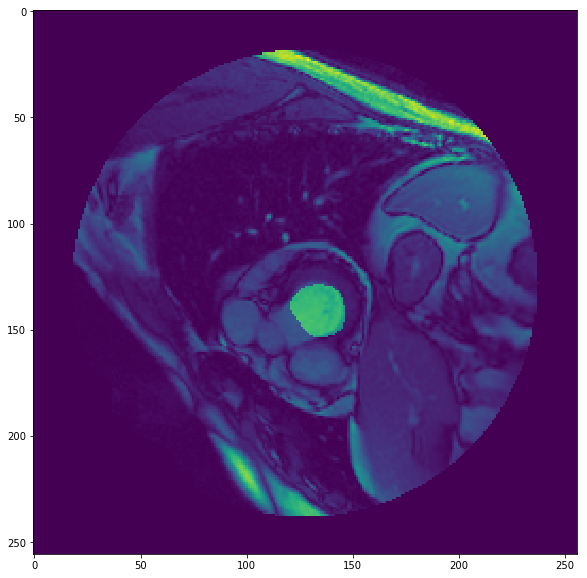

In [16]:
plt.figure(figsize=(10,10))
plt.imshow(400*np.array(icontMask)+np.array(ima))

0 950


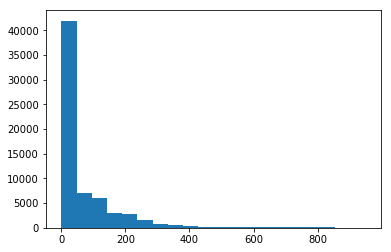

In [18]:
print min(ima.flatten()), max(ima.flatten())
_=plt.hist(ima.flatten(),bins=20)